## CSGO ROUND PREDICTING MODEL
---
In this notebook we are creating a MLP to accurately predict the winner of a CSGO round.
Since the data we are dealing with is tabular we chose to use a standard MLP and focus on expanding upon it

In [41]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Create a Dictionary for easy Hyperparameter tuning

In [42]:
PARAM = {
    'n_epochs': 50,
    'learning_rate': 0.0001,
    
    #normalization function can be min_max, z_score
    'norm_func': 'z_score',
    #optimizer can be SGD or ADAM
    'optim': 'ADAM',
    #architecture can be 0, 1 or 2
    'model_arch' : 2,
}

## Load and Normalize the Data
---
We will load the data from the included csv file "csgo_round_snapshots.csv".


In [ ]:
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler

# percentage of training set to use as validation
valid_size = 0.20
test_size = .05

batch_size = 32


#load the data into a dataframe using pandas
df = pd.read_csv('csgo_round_snapshots.csv')

# obtain training indices that will be used for validation
num_train = len(df)
indices = list(range(num_train))
np.random.shuffle(indices)
split_1 = int(np.floor(valid_size * num_train))
split_2 = int(np.floor(num_train - (test_size * num_train)))
train_idx, valid_idx, test_idx = indices[split_1:split_2], indices[:split_1], indices[split_2:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

#now we must seperate the features from the labels
features = df.drop('round_winner', axis=1)
labels   = df['round_winner']




#perform one hot encoding on the map column
features = pd.get_dummies(features,columns=['map'], drop_first=True)

for column in features.columns:
    #skips if column is a boolean
    if pd.api.types.is_bool_dtype(features[column]):
        continue

    #skips if column does not change in value
    if features[column].max() - features[column].min() == 0:
        continue
    
    if PARAM['norm_func'] == 'min_max':
        features[column] = (features[column] - features[column].min()) / (features[column].max() - features[column].min())
    elif PARAM['norm_func'] == 'z_score':
        features[column] = (features[column] - features[column].mean()) / features[column].std()
    else:
        continue


labels = labels.replace({'CT': 0, 'T': 1})

#had trouble with boolean type conversion now we implicitly change bools to floats
for column in features.select_dtypes(include='bool').columns:
    features[column] = features[column].astype(float)

features.info()


features_np = features.values
labels_np = labels.values

#create tensors from the numpy values
features_tensor = torch.tensor(features_np, dtype=torch.float32)
labels_tensor = torch.tensor(labels_np, dtype=torch.float32).unsqueeze(1)

#combine the two tensors into the dataset
dataset = TensorDataset(features_tensor, labels_tensor)

#create the data loaders to be used to train the model
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(dataset,batch_size=batch_size, sampler=test_sampler)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Columns: 102 entries, time_left to map_de_vertigo
dtypes: float64(102)
memory usage: 95.3 MB


## Define the Architecture
---
We are creating 3 seperate models that can be chosen based off of PARAM['model_arch']
Each architecture adds more layers and neurons deepening the model as we go

In [44]:
import torch.nn as nn
import torch.nn.functional as F

is_Dropout = True

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #defining the layers in the NN  
        if PARAM['model_arch'] == 0 :
            self.output = nn.Linear(102,1)
        elif PARAM['model_arch'] == 1 :

            self.layer1 = nn.Linear(102, 256)
            self.layer2 = nn.Linear(256,102)
            self.output = nn.Linear(102,1)
        elif PARAM['model_arch'] == 2 :
            self.layer1 = nn.Linear(102, 512)
            self.layer2 = nn.Linear(512,256)
            self.layer3 = nn.Linear(256,102)
            self.layer4 = nn.Linear(102,102)
            self.output = nn.Linear(102,1)

        self.dropout = nn.Dropout(0.35)
    
    def forward(self, x):

        if PARAM['model_arch'] == 0 :
            x = F.sigmoid(self.output(x))
        elif PARAM['model_arch'] == 1 : 
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
            if(is_Dropout) : x = self.dropout(x)
            x = F.sigmoid(self.output(x))
        elif PARAM['model_arch'] == 2 :
            x = F.relu(self.layer1(x))
            if(is_Dropout) : x = self.dropout(x)
            x = F.relu(self.layer2(x))
            if(is_Dropout) : x = self.dropout(x)
            x = F.relu(self.layer3(x))
            x = F.relu(self.layer4(x))
            x = F.sigmoid(self.output(x))
        return x


model = Net()
print(model)

#move tensors to GPU if CUDA is available

if train_on_gpu:
    model.cuda()
        

Net(
  (layer1): Linear(in_features=102, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=102, bias=True)
  (layer4): Linear(in_features=102, out_features=102, bias=True)
  (output): Linear(in_features=102, out_features=1, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)


## Specify Loss Function and Optimizer


In [45]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.BCELoss()

# specify optimizer
if PARAM['optim'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), PARAM['learning_rate'])
    print("The optimizer you selected is: SGD")
elif PARAM['optim'] ==  'ADAM':
    print("The optimizer you selected is: ADAM")
    optimizer = optim.Adam(model.parameters(), PARAM['learning_rate'])

The optimizer you selected is: ADAM


## Training the Network


Epoch: 1 	Training Loss: 0.496356 	Validation Loss: 0.459614
Validation loss decreased (inf --> 0.459614).  Saving model ...
Epoch: 2 	Training Loss: 0.461700 	Validation Loss: 0.452820
Validation loss decreased (0.459614 --> 0.452820).  Saving model ...
Epoch: 3 	Training Loss: 0.453008 	Validation Loss: 0.450253
Validation loss decreased (0.452820 --> 0.450253).  Saving model ...
Epoch: 4 	Training Loss: 0.448265 	Validation Loss: 0.446655
Validation loss decreased (0.450253 --> 0.446655).  Saving model ...
Epoch: 5 	Training Loss: 0.443199 	Validation Loss: 0.443363
Validation loss decreased (0.446655 --> 0.443363).  Saving model ...
Epoch: 6 	Training Loss: 0.439476 	Validation Loss: 0.440173
Validation loss decreased (0.443363 --> 0.440173).  Saving model ...
Epoch: 7 	Training Loss: 0.436874 	Validation Loss: 0.438926
Validation loss decreased (0.440173 --> 0.438926).  Saving model ...
Epoch: 8 	Training Loss: 0.432689 	Validation Loss: 0.436941
Validation loss decreased (0.43892

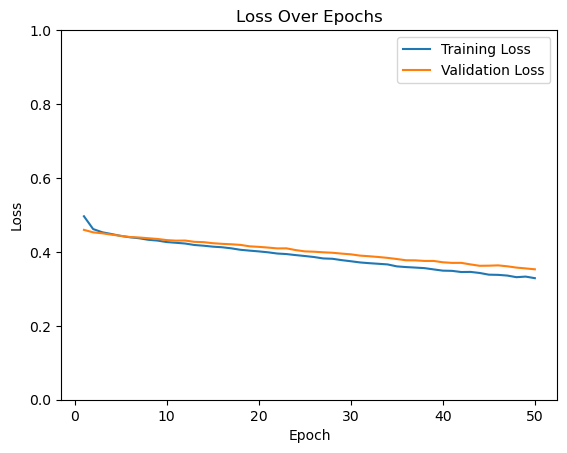

C:\Users\josep\AppData\Local\Temp\ipykernel_8232\1428333273.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_trained.pt'))


<All keys matched successfully>

In [46]:
import matplotlib.pyplot as plt

valid_loss_min = np.Inf
training_loss_list = []
validation_loss_list = []

overfit_Counter = 0

for epoch in range(1, PARAM['n_epochs'] + 1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()


        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()

    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()


        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    training_loss_list.append(train_loss)
    validation_loss_list.append(valid_loss)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = valid_loss
        overfit_Counter = 0
    else:
        overfit_Counter+=1
        if(overfit_Counter >= 3):
            break


#Plot the data to see the Training validation loss curve

plt.plot(range(1, len(training_loss_list) + 1), training_loss_list, label='Training Loss',)
plt.plot(range(1, len(validation_loss_list) + 1), validation_loss_list, label='Validation Loss',)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.ylim(0.0, 1.0) 
plt.legend()
plt.show()


model.load_state_dict(torch.load('model_trained.pt'))

## Test the Network

In [47]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = ['CT', 'T']

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    pred = (output >= .5).float()
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class

    batch_size = data.size(0)
    for i in range(batch_size):
        label = int(target[i].item())
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(2):
    if class_total[i] > 0:
         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
             classes[i], 100 * class_correct[i] / class_total[i],
             int(class_correct[i]), int(class_total[i]))) # Cast sums to int for printing
    else:
         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    int(np.sum(class_correct)), int(np.sum(class_total)))) # Cast sums to int for printing



Test Loss: 0.018086

Test Accuracy of    CT: 85% (2555/2971)
Test Accuracy of     T: 80% (2543/3150)

Test Accuracy (Overall): 83% (5098/6121)
